In [32]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
#import xgboost as xgb
#from xgboost import XGBClassifier

# I am getting error for loading xgboost library. says some dll is missing. Please help me to resolve this.

In [33]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None  # default='warn'

In [34]:
names = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
         "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", 
         "hours-per-week", "native-country", "income"]

In [35]:
original_train = pd.read_csv('adult_data.csv', sep=',', header=None, names=names, na_values="?")
original_test = pd.read_csv('adult_test.csv', sep=',', header=None, names=names, na_values="?")


In [36]:
original_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [37]:
original_test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [38]:
#drop the rows containing missing values
original_train.dropna(inplace=True)
original_test.dropna(inplace=True)

In [39]:
# remove spaces after comma for pandas convenience
original_train[original_train.select_dtypes(['object']).columns] = original_train.select_dtypes(['object']).apply(lambda x: x.str.strip())
original_test[original_test.select_dtypes(['object']).columns] = original_test.select_dtypes(['object']).apply(lambda x: x.str.strip())

In [40]:
original_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


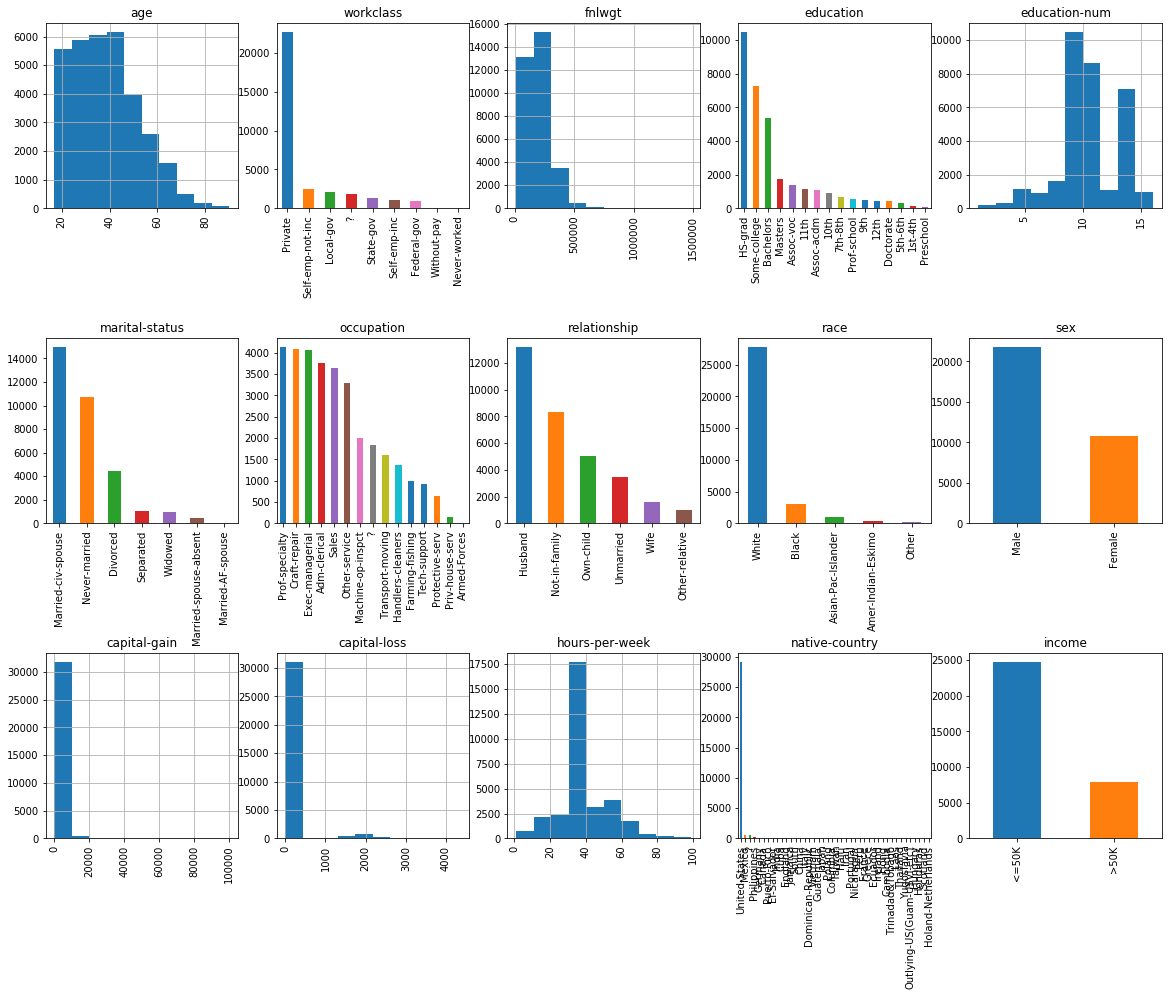

In [41]:
#Distribution of each feature to have a better understanding what we have in our data. We draw the number of values for each category feature and the histogram of the values for each continuous feature.


from math import ceil

fig = plt.figure(figsize=(20,15))
cols = 5
rows = ceil(float(original_train.shape[1]) / cols)
for i, column in enumerate(original_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if original_train.dtypes[column] == np.object:
        original_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        original_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)


We can see from the plots that our data is mostly concentrated in the USA with mostly male white people.

Let’s explore the correlation between the different features. Generally it is not a good idea to have many correlated features, as it might be a sign that your data is not very good. For this purpose we will need to encode the categorical features as numbers.


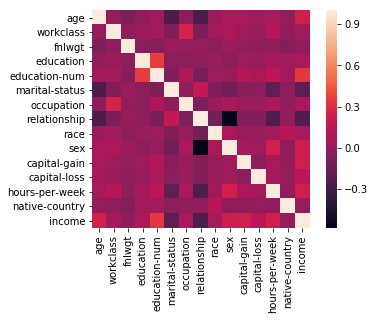

In [42]:
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

# Calculate the correlation and plot it
encoded_train, _ = number_encode_features(original_train)
sns.heatmap(encoded_train.corr(), square=True)
plt.show()

In [43]:
original_train.drop(['education'], axis=1, inplace=True)
encoded_train.drop(['education'], axis=1, inplace=True)
original_test.drop(['education'], axis=1, inplace=True)

In [44]:
#Encode data in test dataframe 

encoded_test, _ = number_encode_features(original_test)

seed = np.random.randint(2**16)
# train set
X_train = encoded_train.drop(columns=['income'], axis=1)
y_train = encoded_train['income']

# test set
X_test = encoded_test.drop(columns=['income'], axis=1)
y_test = encoded_test['income']

# scale the columns between 0 and 1 (normalization)
X_scaler = StandardScaler()
X_train = pd.DataFrame(X_scaler.fit_transform(X_train), columns=X_train.columns)
X_test = X_scaler.transform(X_test)

In [45]:
lrmodel =  LogisticRegression (random_state=seed)
lrmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=51279, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [46]:
predicted  = lrmodel.predict(X_test)
predicted

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

Test Accuracy: 82.45 %
F1 Score: 0.55


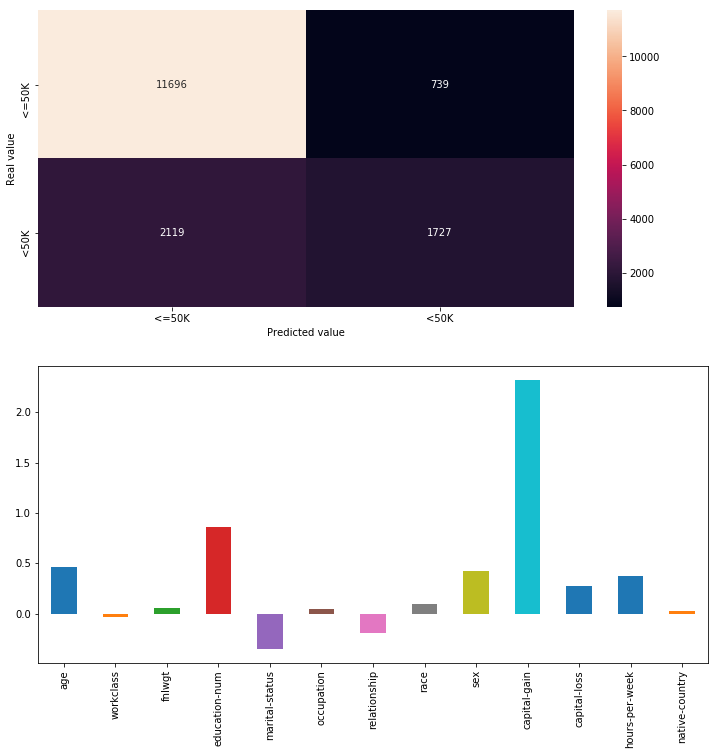

In [47]:
# evaluation metrics
print("Test Accuracy:", format(metrics.accuracy_score(y_test, predicted) * 100, '.2f'), '%')
print("F1 Score:", format(metrics.f1_score(y_test, predicted), '.2f'))

cm = metrics.confusion_matrix(y_test, predicted)
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['<=50K', '<50K'], yticklabels=['<=50K', '<50K'])
plt.ylabel("Real value")
plt.xlabel("Predicted value")

coefs = pd.Series(lrmodel.coef_[0], index=X_train.columns)
plt.subplot(2,1,2)
coefs.plot(kind="bar")
plt.show()

In [48]:
# category columns
train_category = original_train[['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']]

#numeric columns
train_numeric = original_train[np.setdiff1d(encoded_train.columns.tolist(), train_category.columns.tolist())]

# dummify the category column
train_category_dummy = pd.get_dummies(train_category, columns=['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'])

# merge
modified_train = pd.concat([train_category_dummy, train_numeric], axis=1)

In [49]:

# do the same for test data set

test_category = original_test[['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']]
test_numeric = original_test[np.setdiff1d(encoded_test.columns.tolist(), test_category.columns.tolist())]
test_category_dummy = pd.get_dummies(test_category, columns=['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'])
modified_test = pd.concat([test_category_dummy, test_numeric], axis=1)




modified_train['income'] = modified_train['income'].map( {'<=50K': 0, '>50K': 1} )
modified_test['income'] = modified_test['income'].map( {'<=50K': 0, '>50K': 1} )
modified_train.drop(['native-country_Holand-Netherlands'], axis=1, inplace=True)




# train set
X_train = modified_train.drop(columns=['income'], axis=1)
y_train = modified_train['income']

# test set
X_test = modified_test.drop(columns=['income'], axis=1)
y_test = modified_test['income']

X_scaler = StandardScaler()
X_train = pd.DataFrame(X_scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(X_scaler.fit_transform(X_test), columns=X_test.columns)


In [50]:
lrmodel = LogisticRegression(random_state=seed)
lrmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=51279, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [51]:
predicted = lrmodel.predict(X_test)

In [52]:
predicted

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

In [56]:
#Random Forest Classifier

# train set
X_train = encoded_train.drop(columns=['income'], axis=1)
y_train = encoded_train['income']

# test set
X_test = encoded_test.drop(columns=['income'], axis=1)
y_test = encoded_test['income']

# scale the numeric columns between 0 and 1 (normalization)
X_scaler = StandardScaler()
X_train = pd.DataFrame(X_scaler.fit_transform(X_train), columns=X_train.columns)
X_test = X_scaler.transform(X_test)

In [57]:
# Instantiate a random forest model and fit the training set.

rfmodel = RandomForestClassifier(n_jobs=-1, random_state=seed)
rfmodel.fit(X_train, y_train)


predicted = rfmodel.predict(X_test)
predicted

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

In [58]:
print("Test Accuracy:", format(metrics.accuracy_score(y_test, predicted) * 100, '.2f'), '%')
print("F1 Score:", format(metrics.f1_score(y_test, predicted), '.2f'))

Test Accuracy: 84.98 %
F1 Score: 0.64


Text(0.5,442.811,'Predicted value')

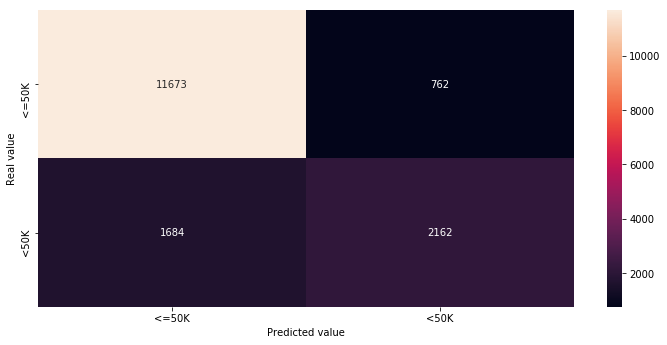

In [59]:
cm = metrics.confusion_matrix(y_test, predicted)
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['<=50K', '<50K'], yticklabels=['<=50K', '<50K'])
plt.ylabel("Real value")
plt.xlabel("Predicted value")

In [60]:
param_test1 = {
 'max_depth': range(3, 10, 2),
 'n_estimators': range(100, 500, 1000),
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 3, 5],
 'max_features': [3, 5, 7],
}

grid_search = GridSearchCV(rfmodel, param_grid=param_test1, scoring="roc_auc", n_jobs=-1, verbose=1)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))



predicted = grid_result.predict(X_test)
predicted

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  3.8min finished


Best: 0.916141 using {'max_depth': 9, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

Test Accuracy: 85.97 %
F1 Score: 0.65


Text(0.5,442.811,'Predicted value')

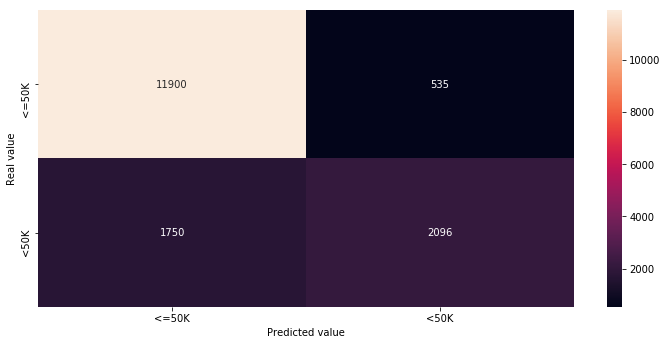

In [61]:
# evaluation metrics
print("Test Accuracy:", format(metrics.accuracy_score(y_test, predicted) * 100, '.2f'), '%')
print("F1 Score:", format(metrics.f1_score(y_test, predicted), '.2f'))

cm = metrics.confusion_matrix(y_test, predicted)
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['<=50K', '<50K'], yticklabels=['<=50K', '<50K'])
plt.ylabel("Real value")
plt.xlabel("Predicted value")